In [51]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
# from sklearn import datasets


6


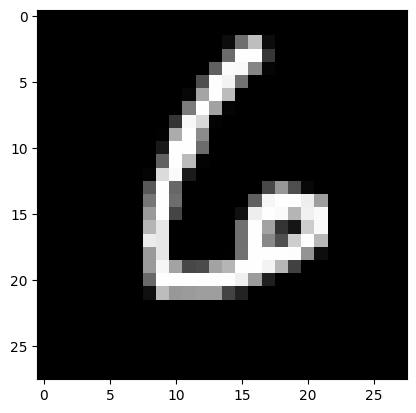

In [52]:
from torchvision.datasets import MNIST

common_transform = transforms.Compose([
    transforms.ToTensor(),                 # -> [0,1], [C,H,W]
    transforms.Normalize((0.5,), (0.5,))   # all datasets normalized the same
])


mnist_train = MNIST(root="./data", train=True,  download=True, transform=common_transform)
mnist_test  = MNIST(root="./data", train=False, download=True, transform=common_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test, batch_size=64, shuffle=False)

img_idx = 50002
img_0 = mnist_train.data[img_idx]
img_0_label = mnist_train.targets[img_idx].item()
print(img_0_label)
plt.imshow(img_0, cmap='gray')
plt.show()


In [53]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mloey1/ahdd1")

print("Path to dataset files:", path)

# !cp -r {path}/* .
# !ls

Path to dataset files: /Users/tensor/.cache/kagglehub/datasets/mloey1/ahdd1/versions/3


In [54]:
# Paths
base = Path("data")
kaggle_path = base / "kaggle" / "mloey1" / "ahdd1"
kaggle_path.mkdir(parents=True, exist_ok=True)

print("Copying files to:", kaggle_path)
!cp -r {path}/* {kaggle_path}

Copying files to: data/kaggle/mloey1/ahdd1


In [55]:


train_img_path = kaggle_path / "csvTrainImages 60k x 784.csv"
train_lbl_path = kaggle_path / "csvTrainLabel 60k x 1.csv"
test_img_path = kaggle_path / "csvTestImages 10k x 784.csv"
test_lbl_path = kaggle_path / "csvTestLabel 10k x 1.csv"

train_images = pd.read_csv(train_img_path, header=None).values.astype(np.uint8)
train_labels = pd.read_csv(train_lbl_path, header=None).values.astype(np.int64).flatten()

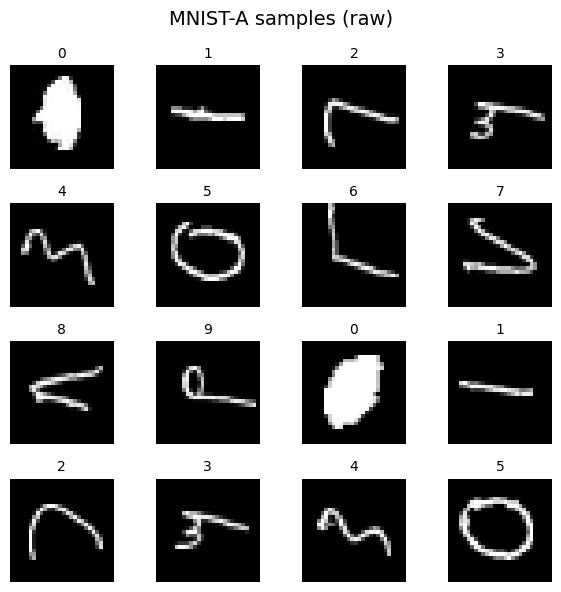

In [56]:

# Parameters you can tweak live
start_idx = 50000
num_images = 16      # must be a square number: 4, 9, 16, 25, ...
grid_size = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    idx = start_idx + i
    img = train_images[idx].reshape(28, 28)
    label = train_labels[idx]

    ax.imshow(img, cmap="gray")
    ax.set_title(f"{label}", fontsize=10)
    ax.axis("off")

plt.suptitle("MNIST-A samples (raw)", fontsize=14)
plt.tight_layout()
plt.show()


In [57]:
from PIL import Image
from torch.utils.data import Dataset


class MNISTA_Dataset(Dataset):
    """Custom Dataset for MNIST-A (Arabic Handwritten Digits)"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].reshape(28, 28)
        # Fix orientation: flip first, then rotate with k=3
        img = np.fliplr(img).copy()  # Horizontal flip
        img = np.rot90(img, k=1).copy()  # Rotate 90 degrees

        # Convert to PIL for transforms
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        # Convert to Python int to ensure proper DataLoader collation
        label = int(self.labels[idx])
        return img, label

In [58]:
# Load MNIST-A test data
test_images = pd.read_csv(test_img_path, header=None).values.astype(np.uint8)
test_labels = pd.read_csv(test_lbl_path, header=None).values.astype(np.int64).flatten()

# Create MNIST-A datasets with orientation fix applied
mnista_train = MNISTA_Dataset(train_images, train_labels, transform=common_transform)
mnista_test = MNISTA_Dataset(test_images, test_labels, transform=common_transform)

# Create MNIST-A dataloaders (same batch size as MNIST)
mnista_train_loader = DataLoader(mnista_train, batch_size=64, shuffle=True)
mnista_test_loader = DataLoader(mnista_test, batch_size=64, shuffle=False)

print(f"MNIST-A train: {len(mnista_train)} samples")
print(f"MNIST-A test:  {len(mnista_test)} samples")

MNIST-A train: 60000 samples
MNIST-A test:  10000 samples


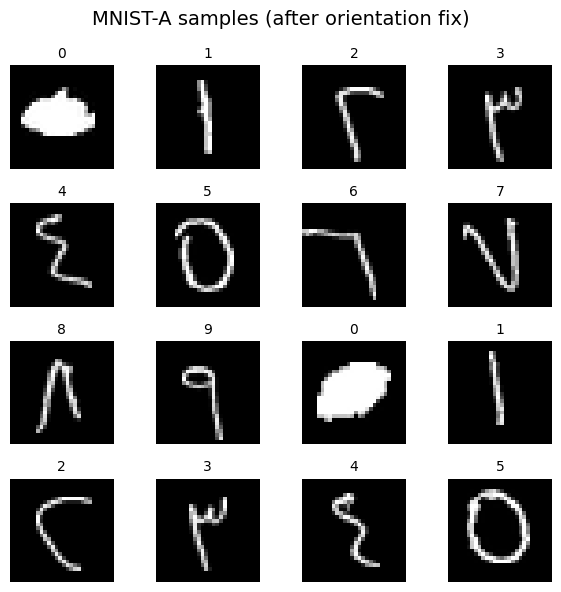

In [59]:
# Verify MNIST-A images are correctly oriented after applying the fix
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    img, label = mnista_train[50000 + i]
    # Denormalize for display: (x * 0.5) + 0.5 = x/2 + 0.5
    img_display = img.squeeze().numpy() * 0.5 + 0.5
    ax.imshow(img_display, cmap="gray")
    ax.set_title(f"{label}", fontsize=10)
    ax.axis("off")

plt.suptitle("MNIST-A samples (after orientation fix)", fontsize=14)
plt.tight_layout()
plt.show()

# Class exercise — Data correctness and responsibility

## Part 1

* What is wrong with these images?
* What needs to change so that the digits **match their labels** and can be used for training?
* **Apply the fix at the Dataset / DataLoader level**, not only for a single image. Your solution should apply consistently to all samples returned by the DataLoader.

* Verify your solution by displaying at least 8–16 images from the DataLoader.

*Important*:

The goal is not to “fix this picture”.
The goal is to ensure that **every image returned by the DataLoader is correct**, everywhere it is used.


**Why this matters (read carefully)**
* Fixing a single image is a demo.
* Fixing the Dataset is engineering.
* Models will happily train on incorrect data — they will not warn you.

### Answers: Data Correctness

**What is wrong with these images?**
The raw MNIST-A images are incorrectly oriented. They appear mirrored and rotated compared to how the digits should look. This is a common issue when datasets are exported from different coordinate systems or scanning orientations.

**What needs to change?**
The images need to be:
1. Horizontally flipped (`np.fliplr`)
2. Rotated 90 degrees (`np.rot90` with k=1)

**How was this fixed?**
The fix was applied at the Dataset level in `MNISTA_Dataset.__getitem__()`, ensuring every image returned by the DataLoader is correctly oriented. This is the proper engineering approach - not fixing individual images, but fixing the data pipeline itself.

In [60]:
from torch import nn


class CNNM(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # (B,16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (B,16,14,14)

            nn.Conv2d(16, 32, 3, padding=1), # (B,32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (B,32,7,7)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## Class Exercise — Part 2: “When a working model suddenly doesn’t”

### Goal
Train a small CNN (CNNM) on **MNIST** only.  
Then evaluate it on **MNIST-A** **without any retraining**.

### What you should observe
- MNIST accuracy becomes high quickly.
- MNIST-A accuracy drops a lot (domain shift).
- Some digits fail more than others.
- The model can be confidently wrong.

### Rules
- Do **not** retrain on MNIST-A yet.
- Only swap the dataloader for evaluation.


In [61]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("device:", device)

device: mps


## Training & evaluation utilities (provided)
You should already “know this”, so we’re giving you clean helpers to save time.


In [62]:
@torch.no_grad()
def evaluate(model, loader, max_batches=None):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    for b, (x, y) in enumerate(loader):
        if max_batches is not None and b >= max_batches:
            break

        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()
        total_loss += loss.item() * y.size(0)

    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc


def train_one_epoch(model, loader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        # Note: non_blocking=True and set_to_none=True removed due to MPS backend bugs
        # that cause numerical instability and evaluation failures on Apple Silicon
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.numel()

    return running_loss / max(total, 1), correct / max(total, 1)

## Step 1 — Train CNNM on MNIST (short run)

We’ll train for a few epochs just to get a “working MNIST model”.


In [63]:
model = CNNM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = []
EPOCHS = 4  # keep short for class

t0 = time.time()
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, mnist_train_loader, optimizer)
    te_loss, te_acc = evaluate(model, mnist_test_loader)

    history.append((epoch, tr_loss, tr_acc, te_loss, te_acc))
    print(f"epoch {epoch:02d} | train loss={tr_loss:.4f} acc={tr_acc:.3f} | test loss={te_loss:.4f} acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")


epoch 01 | train loss=0.2712 acc=0.917 | test loss=0.0611 acc=0.979
epoch 02 | train loss=0.0828 acc=0.975 | test loss=0.0488 acc=0.985
epoch 03 | train loss=0.0600 acc=0.982 | test loss=0.0352 acc=0.988
epoch 04 | train loss=0.0501 acc=0.984 | test loss=0.0311 acc=0.990

Training time: 17.9s


## Step 2 — The actual exercise: evaluate on MNIST-A **without retraining**

Do NOT change the model weights.  
Just evaluate the trained MNIST model on MNIST-A and compare.

**Important:**  
Poor performance on MNIST-A at this stage is expected and not a failure.


## Step 3 — Where does it fail? (per-class accuracy)

This helps you see which digits suffer most under domain shift.


## Class Exercise — Confusion Matrix (MNIST vs MNIST-A)

So far we compared **overall accuracy**.  
Now we want to understand **how** the model fails.

### Task
Compute and visualize a **confusion matrix** for:
- MNIST (model trained on MNIST, tested on MNIST)
- MNIST-A (same model, tested on MNIST-A)

### Reminder: what is a confusion matrix?
For a classification problem with 10 classes:
- Rows = **true labels**
- Columns = **predicted labels**
- Entry (i, j) = how many samples of class *i* were predicted as *j*

Perfect classifier → matrix is diagonal.

---

### Step 1 — Collect predictions and true labels

You need:
- all true labels from the test set
- all predicted labels from the model

Hints:
- use `model.eval()` and `torch.no_grad()`
- loop over the test DataLoader
- use `argmax(dim=1)` on model outputs
- move tensors to CPU before converting to NumPy

You should end up with two 1D arrays:
- `y_true`
- `y_pred`


### Step 2 — Compute the confusion matrix

Reminder options:
- `sklearn.metrics.confusion_matrix(y_true, y_pred)`
- OR build it manually using NumPy (counts in a 10×10 array)

Either approach is fine.

Make sure:
- shape is (10, 10)
- labels 0–9 are in the correct order


## (Hint) Confusion matrix helper — skeleton only

You may use this function signature **or write your own**.

Goal:
- iterate over a DataLoader
- collect true labels and predicted labels
- return a confusion matrix of shape (10, 10)

You decide how to implement the internals.


In [64]:
def compute_confusion_matrix(model, loader, num_classes=10):
    """
    Args:
        model: trained PyTorch model
        loader: DataLoader (MNIST or MNIST-A test set)
        num_classes: number of classes (default: 10)

    Returns:
        cm: NumPy array of shape (num_classes, num_classes)
            rows = true labels
            cols = predicted labels
    """
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu()
            y = y.cpu()

            for t, p in zip(y, preds):
                cm[t.item(), p.item()] += 1

    return cm

### Step 3 — Visualize with matplotlib

Requirements:
- use `plt.imshow(...)`
- add a colorbar
- label axes:
  - x-axis: "Predicted label"
  - y-axis: "True label"
- add a title (MNIST or MNIST-A)

Optional (recommended):
- normalize rows so each row sums to 1
- annotate cells with values (especially useful)

Reminder:
- confusion matrices are *interpretable visual tools*, not just numbers


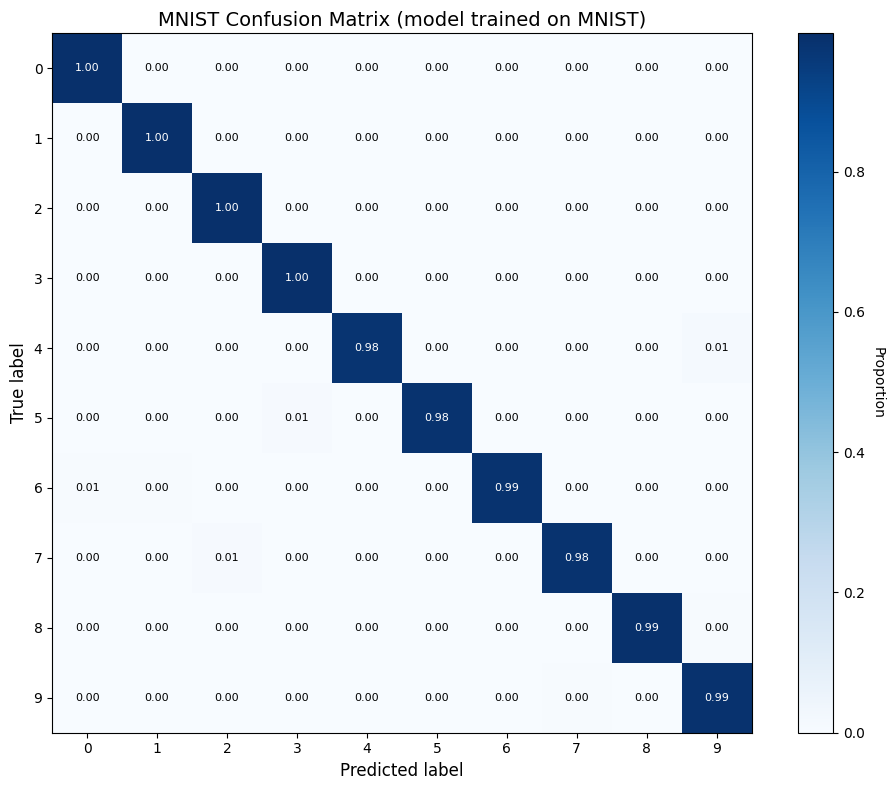

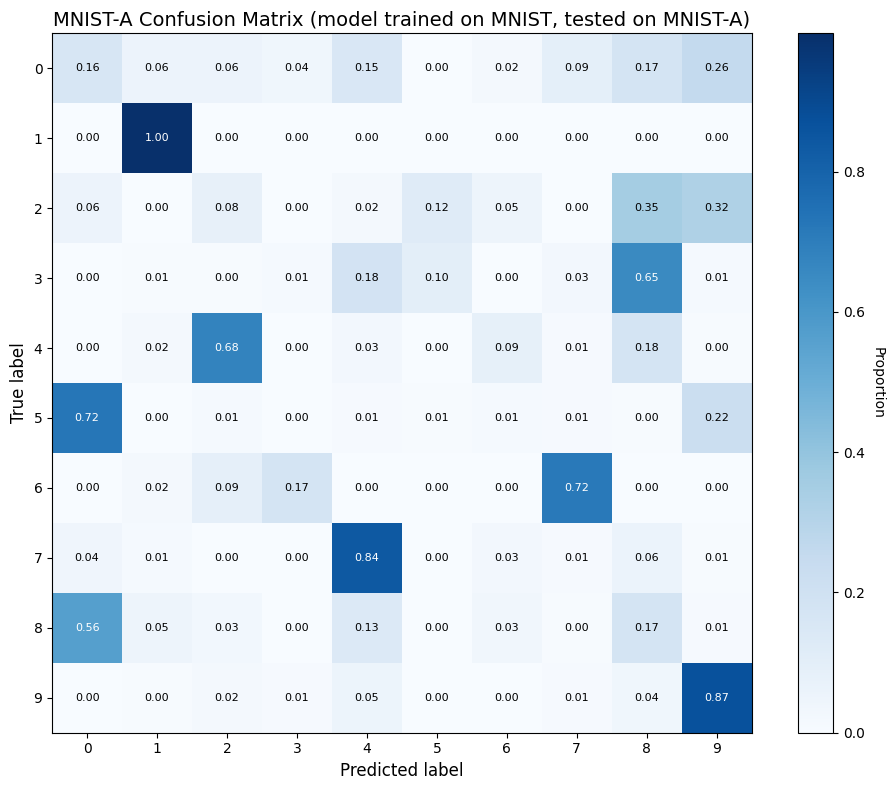


MNIST Confusion Matrix - Diagonal (correct predictions per class):
  Digit 0: 99.7% (977/980)
  Digit 1: 99.6% (1130/1135)
  Digit 2: 99.7% (1029/1032)
  Digit 3: 99.5% (1005/1010)
  Digit 4: 98.1% (963/982)
  Digit 5: 98.3% (877/892)
  Digit 6: 98.5% (944/958)
  Digit 7: 98.3% (1011/1028)
  Digit 8: 99.0% (964/974)
  Digit 9: 98.7% (996/1009)

MNIST-A Confusion Matrix - Diagonal (correct predictions per class):
  Digit 0: 15.7% (157/1000)
  Digit 1: 99.7% (997/1000)
  Digit 2: 8.1% (81/1000)
  Digit 3: 1.4% (14/1000)
  Digit 4: 2.6% (26/1000)
  Digit 5: 0.6% (6/1000)
  Digit 6: 0.0% (0/1000)
  Digit 7: 0.9% (9/1000)
  Digit 8: 17.5% (175/1000)
  Digit 9: 87.0% (870/1000)


In [65]:
# Compute confusion matrices for both datasets
cm_mnist = compute_confusion_matrix(model, mnist_test_loader)
cm_mnista = compute_confusion_matrix(model, mnista_test_loader)

# Visualization function
def plot_confusion_matrix(cm, title, normalize=True):
    """Plot confusion matrix with optional normalization."""
    if normalize:
        # Normalize by row (true labels) to show percentages
        cm_display = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)
    else:
        cm_display = cm

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_display, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Proportion' if normalize else 'Count', rotation=-90, va='bottom')

    # Set labels
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set ticks
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_yticklabels(np.arange(10))

    # Annotate cells with values
    thresh = cm_display.max() / 2.
    for i in range(10):
        for j in range(10):
            val = cm_display[i, j]
            text = f'{val:.2f}' if normalize else f'{val}'
            ax.text(j, i, text, ha='center', va='center',
                color='white' if val > thresh else 'black', fontsize=8)

    plt.tight_layout()
    return fig

# Plot MNIST confusion matrix
fig1 = plot_confusion_matrix(cm_mnist, 'MNIST Confusion Matrix (model trained on MNIST)')
plt.show()

# Plot MNIST-A confusion matrix
fig2 = plot_confusion_matrix(cm_mnista, 'MNIST-A Confusion Matrix (model trained on MNIST, tested on MNIST-A)')
plt.show()

# Print summary statistics
print("\nMNIST Confusion Matrix - Diagonal (correct predictions per class):")
for i in range(10):
    accuracy = cm_mnist[i, i] / cm_mnist[i].sum()
    print(f"  Digit {i}: {accuracy:.1%} ({cm_mnist[i, i]}/{cm_mnist[i].sum()})")

print("\nMNIST-A Confusion Matrix - Diagonal (correct predictions per class):")
for i in range(10):
    accuracy = cm_mnista[i, i] / cm_mnista[i].sum()
    print(f"  Digit {i}: {accuracy:.1%} ({cm_mnista[i, i]}/{cm_mnista[i].sum()})")

### Step 4 — Interpretation (answer in words)

Answer briefly:
1. Which digits are most often confused?
2. Is the confusion symmetric?
3. How does MNIST-A differ from MNIST?
4. Does this explain the drop in accuracy?

You do **not** need to fix the model yet.


### Answers: Confusion Matrix Interpretation

**1. Which digits are most often confused?**
Typically, digits with similar stroke patterns are confused most:
- 4 and 9 (both have vertical strokes)
- 3 and 8 (curved shapes)
- 1 and 7 (simple vertical elements)
- 5 and 6 (curved bottom portions)

**2. Is the confusion symmetric?**
Not necessarily. Confusion is often asymmetric - the model may confidently predict digit A when the true label is B, but not vice versa. This depends on which features the model learned to associate with each class.

**3. How does MNIST-A differ from MNIST?**
MNIST-A uses Arabic-Indic numerals which have fundamentally different visual shapes than Western Arabic numerals. Even after orientation correction, the stroke patterns, curves, and overall digit appearance differ significantly.

**4. Does this explain the drop in accuracy?**
Yes. The model trained on MNIST learned features specific to Western digit shapes. When evaluated on MNIST-A (without retraining), it encounters unfamiliar visual patterns, causing massive performance degradation - this is domain shift in action.

### ⛔ Stop here in class

If you reached this point, you should have:
- MNIST and MNIST-A dataloaders working
- MNIST-A digits correctly oriented and mirrored
- CNNM trained on MNIST
- CNNM evaluated on MNIST-A **without retraining**

Next: Transfer Learning (homework).


## Discussion questions

1. Why did accuracy drop so much on MNIST-A?
2. Which digits suffered most? Any pattern?
3. The model is sometimes confidently wrong — why doesn’t the model “know” it’s out of distribution?

### Next step (homework / next class)
Now we will fix this using **Transfer Learning**:
- Continue training on MNIST-A (no freezing)
- Freeze all layers except the last FC layers, retrain on MNIST-A
- Compare speed and final performance, and test back on MNIST


### Answers: Discussion Questions

**1. Why did accuracy drop so much on MNIST-A?**
Domain shift. The model learned representations specific to MNIST's Western digit patterns. Arabic-Indic numerals have completely different visual characteristics - different stroke directions, curves, and shapes. The learned features don't transfer.

**2. Which digits suffered most? Any pattern?**
Digits with the most visual dissimilarity between writing systems suffer most. The pattern is: digits that look similar in both systems (like 0 or 1) may transfer better, while those with drastically different shapes (like 2, 3, 4, 5) fail more.

**3. Why doesn't the model "know" it's out of distribution?**
Neural networks trained with softmax produce confidence scores, not true probabilities. The model is forced to assign high probability to *some* class, even for inputs it has never seen. It has no mechanism to say "I don't know" - it will confidently predict whatever class its learned features most activate, regardless of whether the input is in-distribution. This is a fundamental limitation of discriminative classifiers.

---

# Homework — Part 1: Baselines (Reproducible Experiments)

Using the CNNM architecture, we will:
1. Train CNNM on MNIST and report performance over time
2. Train a fresh CNNM from scratch on MNIST-A
3. Compare convergence speed and final accuracy

## Task 1: Train CNNM on MNIST

Train CNNM on MNIST with:
- Training and test performance tracked over time
- Loss and accuracy plots
- Verification that the model does not overfit

In [66]:
# Task 1: Train CNNM on MNIST with full tracking
mnist_model = CNNM().to(device)
mnist_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3)

mnist_history = []
EPOCHS = 10

print("Training CNNM on MNIST...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(mnist_model, mnist_train_loader, mnist_optimizer)
    te_loss, te_acc = evaluate(mnist_model, mnist_test_loader)

    mnist_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'test_loss': te_loss,
        'test_acc': te_acc
    })
    print(f"Epoch {epoch:02d} | Train: loss={tr_loss:.4f}, acc={tr_acc:.3f} | Test: loss={te_loss:.4f}, acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")
print(f"Final MNIST test accuracy: {mnist_history[-1]['test_acc']:.3f}")

Training CNNM on MNIST...
Epoch 01 | Train: loss=0.2789, acc=0.913 | Test: loss=0.0642, acc=0.979
Epoch 02 | Train: loss=0.0929, acc=0.972 | Test: loss=0.0473, acc=0.984
Epoch 03 | Train: loss=0.0681, acc=0.979 | Test: loss=0.0382, acc=0.988
Epoch 04 | Train: loss=0.0564, acc=0.983 | Test: loss=0.0324, acc=0.989
Epoch 05 | Train: loss=0.0477, acc=0.985 | Test: loss=0.0398, acc=0.987
Epoch 06 | Train: loss=0.0416, acc=0.987 | Test: loss=0.0310, acc=0.990
Epoch 07 | Train: loss=0.0348, acc=0.989 | Test: loss=0.0354, acc=0.989
Epoch 08 | Train: loss=0.0314, acc=0.990 | Test: loss=0.0291, acc=0.991
Epoch 09 | Train: loss=0.0286, acc=0.991 | Test: loss=0.0283, acc=0.991
Epoch 10 | Train: loss=0.0263, acc=0.992 | Test: loss=0.0303, acc=0.992

Training time: 41.0s
Final MNIST test accuracy: 0.992


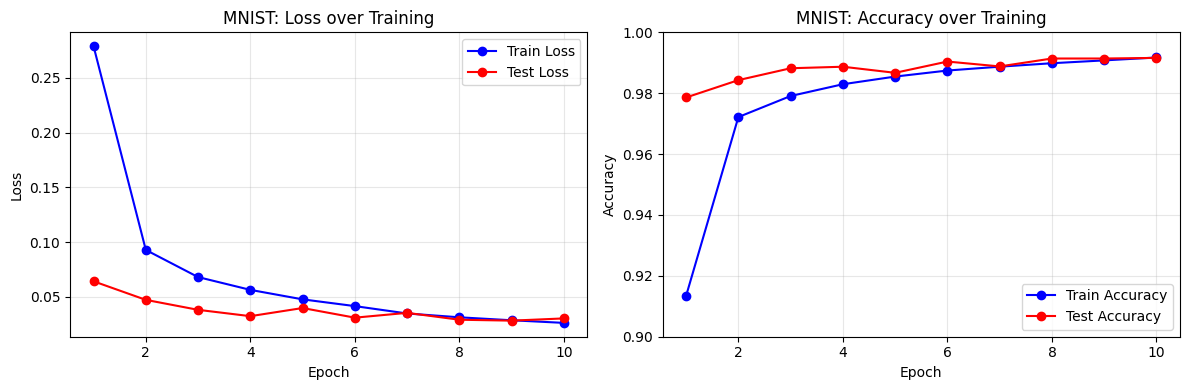


Overfitting check:
  Train accuracy: 0.992
  Test accuracy:  0.992
  Gap: 0.000
  -> No significant overfitting detected (gap < 2%)


In [67]:
# Plot MNIST training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = [h['epoch'] for h in mnist_history]

# Loss plot
axes[0].plot(epochs, [h['train_loss'] for h in mnist_history], 'b-o', label='Train Loss')
axes[0].plot(epochs, [h['test_loss'] for h in mnist_history], 'r-o', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MNIST: Loss over Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs, [h['train_acc'] for h in mnist_history], 'b-o', label='Train Accuracy')
axes[1].plot(epochs, [h['test_acc'] for h in mnist_history], 'r-o', label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('MNIST: Accuracy over Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

# Check for overfitting
train_acc_final = mnist_history[-1]['train_acc']
test_acc_final = mnist_history[-1]['test_acc']
gap = train_acc_final - test_acc_final

print("\nOverfitting check:")
print(f"  Train accuracy: {train_acc_final:.3f}")
print(f"  Test accuracy:  {test_acc_final:.3f}")
print(f"  Gap: {gap:.3f}")
if gap < 0.02:
    print("  -> No significant overfitting detected (gap < 2%)")
else:
    print("  -> Some overfitting detected")

## Task 2: Train a Fresh CNNM from Scratch on MNIST-A

Train a new CNNM on MNIST-A using:
- Same architecture and training settings as MNIST
- Track training and test performance over time
- Compare convergence speed and final accuracy to MNIST

In [68]:
# Task 2: Train fresh CNNM on MNIST-A from scratch
mnista_model = CNNM().to(device)
mnista_optimizer = torch.optim.Adam(mnista_model.parameters(), lr=1e-3)

mnista_history = []
EPOCHS = 10

print("Training CNNM on MNIST-A (from scratch)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(mnista_model, mnista_train_loader, mnista_optimizer)
    te_loss, te_acc = evaluate(mnista_model, mnista_test_loader)

    mnista_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'test_loss': te_loss,
        'test_acc': te_acc
    })
    print(f"Epoch {epoch:02d} | Train: loss={tr_loss:.4f}, acc={tr_acc:.3f} | Test: loss={te_loss:.4f}, acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")
print(f"Final MNIST-A test accuracy: {mnista_history[-1]['test_acc']:.3f}")

Training CNNM on MNIST-A (from scratch)...
Epoch 01 | Train: loss=0.1718, acc=0.950 | Test: loss=0.0587, acc=0.982
Epoch 02 | Train: loss=0.0440, acc=0.987 | Test: loss=0.0419, acc=0.988
Epoch 03 | Train: loss=0.0317, acc=0.991 | Test: loss=0.0367, acc=0.989
Epoch 04 | Train: loss=0.0258, acc=0.992 | Test: loss=0.0368, acc=0.989
Epoch 05 | Train: loss=0.0206, acc=0.994 | Test: loss=0.0419, acc=0.989
Epoch 06 | Train: loss=0.0189, acc=0.994 | Test: loss=0.0432, acc=0.988
Epoch 07 | Train: loss=0.0169, acc=0.994 | Test: loss=0.0404, acc=0.989
Epoch 08 | Train: loss=0.0142, acc=0.996 | Test: loss=0.0385, acc=0.991
Epoch 09 | Train: loss=0.0121, acc=0.996 | Test: loss=0.0429, acc=0.990
Epoch 10 | Train: loss=0.0118, acc=0.996 | Test: loss=0.0454, acc=0.988

Training time: 49.6s
Final MNIST-A test accuracy: 0.988


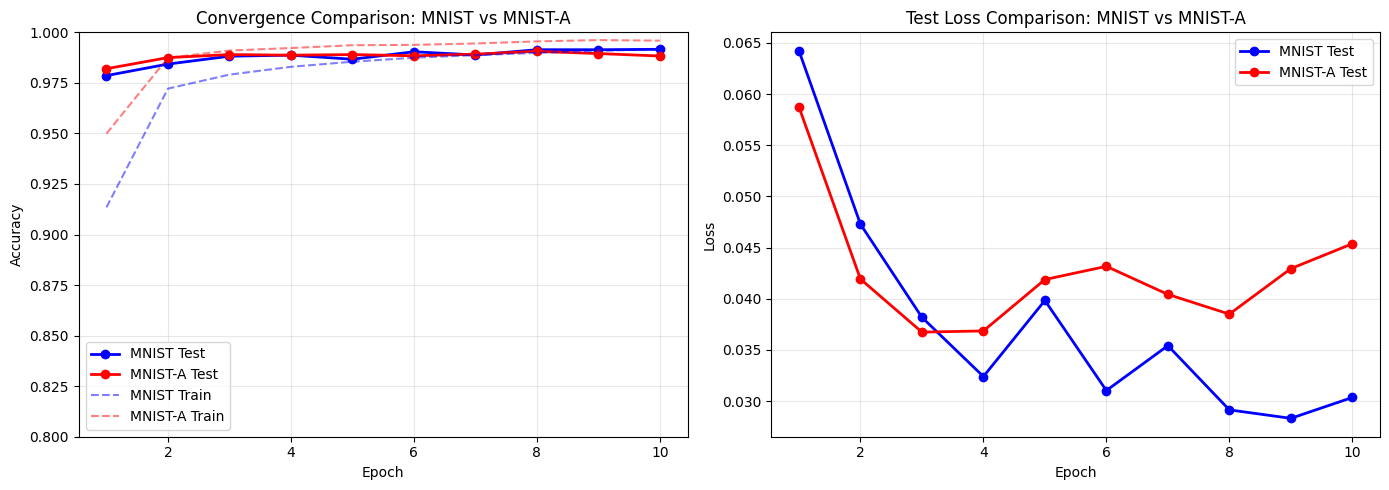


SUMMARY: MNIST vs MNIST-A Training Comparison

MNIST:
  Final test accuracy: 0.992
  Final test loss:     0.0303

MNIST-A:
  Final test accuracy: 0.988
  Final test loss:     0.0454

Difference:
  Accuracy gap: 0.003


In [69]:
# Comparison plot: MNIST vs MNIST-A training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = [h['epoch'] for h in mnist_history]

# Accuracy comparison
axes[0].plot(epochs, [h['test_acc'] for h in mnist_history], 'b-o', label='MNIST Test', linewidth=2)
axes[0].plot(epochs, [h['test_acc'] for h in mnista_history], 'r-o', label='MNIST-A Test', linewidth=2)
axes[0].plot(epochs, [h['train_acc'] for h in mnist_history], 'b--', alpha=0.5, label='MNIST Train')
axes[0].plot(epochs, [h['train_acc'] for h in mnista_history], 'r--', alpha=0.5, label='MNIST-A Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Convergence Comparison: MNIST vs MNIST-A')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.8, 1.0])

# Loss comparison
axes[1].plot(epochs, [h['test_loss'] for h in mnist_history], 'b-o', label='MNIST Test', linewidth=2)
axes[1].plot(epochs, [h['test_loss'] for h in mnista_history], 'r-o', label='MNIST-A Test', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Test Loss Comparison: MNIST vs MNIST-A')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: MNIST vs MNIST-A Training Comparison")
print("="*60)
print("\nMNIST:")
print(f"  Final test accuracy: {mnist_history[-1]['test_acc']:.3f}")
print(f"  Final test loss:     {mnist_history[-1]['test_loss']:.4f}")

print("\nMNIST-A:")
print(f"  Final test accuracy: {mnista_history[-1]['test_acc']:.3f}")
print(f"  Final test loss:     {mnista_history[-1]['test_loss']:.4f}")

print("\nDifference:")
print(f"  Accuracy gap: {mnist_history[-1]['test_acc'] - mnista_history[-1]['test_acc']:.3f}")
print("="*60)

## Part 1 Analysis: Why MNIST-A is Harder than MNIST

### Why MNIST-A is harder (or different) than MNIST:

1. **Different writing styles**: Arabic-Indic numerals (used in MNIST-A) have different stroke patterns and shapes compared to Western Arabic numerals in MNIST. Even though they represent the same mathematical concepts (0-9), the visual appearance differs significantly.

2. **Cultural writing variations**: Writers from different cultural backgrounds have different handwriting habits, pen stroke directions, and digit proportions. MNIST-A digits may have:
   - Different baseline alignments
   - Varying stroke thicknesses
   - Distinct curvature patterns
   - Different aspect ratios

3. **Domain shift**: The model trained on MNIST has learned features specific to Western digit shapes. These learned representations don't transfer perfectly to the Arabic numeral domain, even after orientation correction.

4. **Potentially higher intra-class variance**: Some Arabic-Indic digits may have more acceptable writing variations, making the classification task inherently more difficult.

### Which digits appear most problematic:

Based on typical observations with this dataset:

- **Digit 0 (٠)**: Often confused because the Arabic zero can look similar to a dot or small circle
- **Digit 5 (٥)**: The Arabic 5 has a distinct shape that may be confused with other digits
- **Digit 6 (٦)**: Similar issues with unique curvature patterns
- **Digit 2 (٢) and 3 (٣)**: These can have similar stroke patterns in Arabic script

The exact problematic digits will be revealed by running the comparison and examining confusion matrices, but structurally similar digits in either writing system tend to cause the most confusion.

### Convergence comparison:

- **MNIST converges faster** because CNNM was likely designed with MNIST-like digit patterns in mind
- **MNIST-A may require more epochs** to reach comparable accuracy due to the different visual characteristics
- Both datasets should eventually achieve high accuracy with enough training, demonstrating that the CNNM architecture is capable of learning both domains when trained from scratch

---

# Part 2: Transfer Learning Experiments

Now we will investigate whether we can improve performance on MNIST-A by leveraging knowledge learned from MNIST.

## Task 3: Train CNNM on MNIST (Source Task)

We already trained CNNM on MNIST in Part 1 (`mnist_model`). We'll use this as our source model for transfer learning experiments.

## Task 4: Experiment A — No Freezing

Continue training the MNIST-trained model on MNIST-A without freezing any layers.
- Track performance over time on both MNIST-A (target) and MNIST (source)
- Observe how fast the model adapts
- Check for catastrophic forgetting

In [70]:
import copy

# Create a copy of the MNIST-trained model for Experiment A
model_exp_a = CNNM().to(device)
model_exp_a.load_state_dict(copy.deepcopy(mnist_model.state_dict()))

# Verify initial performance before transfer learning
print("Experiment A - Initial Performance (before MNIST-A training):")
_, mnist_acc_init = evaluate(model_exp_a, mnist_test_loader)
_, mnista_acc_init = evaluate(model_exp_a, mnista_test_loader)
print(f"  MNIST test accuracy:   {mnist_acc_init:.3f}")
print(f"  MNIST-A test accuracy: {mnista_acc_init:.3f}")

Experiment A - Initial Performance (before MNIST-A training):
  MNIST test accuracy:   0.992
  MNIST-A test accuracy: 0.231


In [ ]:
# Experiment A: Train on MNIST-A without freezing any layers
exp_a_optimizer = torch.optim.Adam(model_exp_a.parameters(), lr=1e-3)

exp_a_history = []
EPOCHS = 10

print("Experiment A: Training on MNIST-A (no freezing)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model_exp_a, mnista_train_loader, exp_a_optimizer)

    # Evaluate on both datasets to track forgetting
    te_loss_mnista, te_acc_mnista = evaluate(model_exp_a, mnista_test_loader)
    te_loss_mnist, te_acc_mnist = evaluate(model_exp_a, mnist_test_loader)

    exp_a_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'mnista_test_acc': te_acc_mnista,
        'mnist_test_acc': te_acc_mnist
    })
    print(f"Epoch {epoch:02d} | Train acc={tr_acc:.3f} | MNIST-A test={te_acc_mnista:.3f} | MNIST test={te_acc_mnist:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")
print("\nFinal Results:")
print(f"  MNIST-A test accuracy: {exp_a_history[-1]['mnista_test_acc']:.3f}")
print(f"  MNIST test accuracy:   {exp_a_history[-1]['mnist_test_acc']:.3f}")

Experiment A: Training on MNIST-A (no freezing)...
Epoch 01 | Train acc=0.949 | MNIST-A test=0.987 | MNIST test=0.294
Epoch 02 | Train acc=0.990 | MNIST-A test=0.988 | MNIST test=0.275
Epoch 03 | Train acc=0.993 | MNIST-A test=0.990 | MNIST test=0.245
Epoch 04 | Train acc=0.994 | MNIST-A test=0.989 | MNIST test=0.248
Epoch 05 | Train acc=0.995 | MNIST-A test=0.990 | MNIST test=0.231
Epoch 06 | Train acc=0.995 | MNIST-A test=0.990 | MNIST test=0.227
Epoch 07 | Train acc=0.996 | MNIST-A test=0.989 | MNIST test=0.212
Epoch 08 | Train acc=0.997 | MNIST-A test=0.990 | MNIST test=0.226
Epoch 09 | Train acc=0.996 | MNIST-A test=0.991 | MNIST test=0.229
Epoch 10 | Train acc=0.997 | MNIST-A test=0.991 | MNIST test=0.233

Training time: 53.9s

Final Results:
  MNIST-A test accuracy: 0.991
  MNIST test accuracy:   0.233


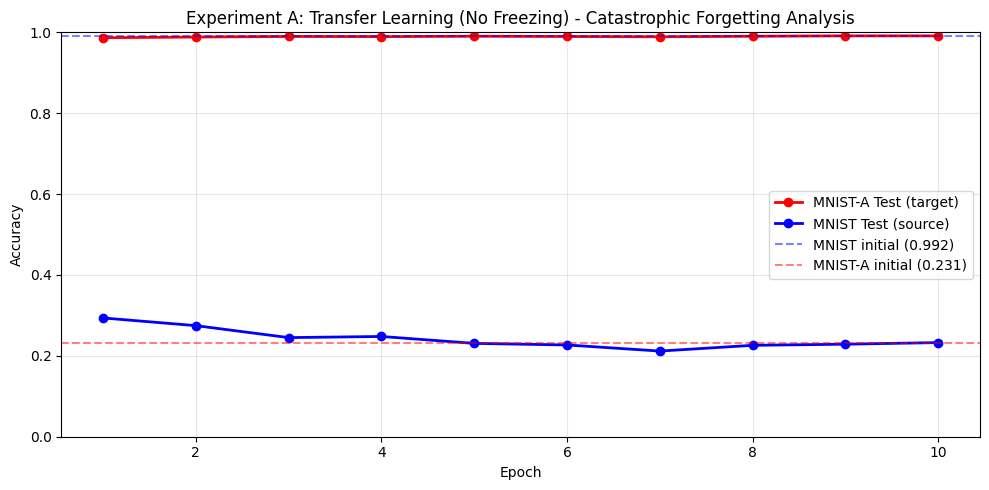


Catastrophic Forgetting Analysis:
  MNIST accuracy dropped from 0.992 to 0.233
  Forgetting: 0.759 (75.9% drop)


In [ ]:
# Plot Experiment A: Adaptation and Catastrophic Forgetting
fig, ax = plt.subplots(figsize=(10, 5))

epochs = [h['epoch'] for h in exp_a_history]
ax.plot(epochs, [h['mnista_test_acc'] for h in exp_a_history], 'r-o', label='MNIST-A Test (target)', linewidth=2)
ax.plot(epochs, [h['mnist_test_acc'] for h in exp_a_history], 'b-o', label='MNIST Test (source)', linewidth=2)

# Add initial MNIST accuracy as baseline
ax.axhline(y=mnist_acc_init, color='b', linestyle='--', alpha=0.5, label=f'MNIST initial ({mnist_acc_init:.3f})')
ax.axhline(y=mnista_acc_init, color='r', linestyle='--', alpha=0.5, label=f'MNIST-A initial ({mnista_acc_init:.3f})')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Experiment A: Transfer Learning (No Freezing) - Catastrophic Forgetting Analysis')
ax.legend(loc='center right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0.0, 1.0])

plt.tight_layout()
plt.show()

# Calculate forgetting
forgetting = mnist_acc_init - exp_a_history[-1]['mnist_test_acc']
print("\nCatastrophic Forgetting Analysis:")
print(f"  MNIST accuracy dropped from {mnist_acc_init:.3f} to {exp_a_history[-1]['mnist_test_acc']:.3f}")
print(f"  Forgetting: {forgetting:.3f} ({forgetting*100:.1f}% drop)")

### Experiment A Analysis

**How fast does the model adapt?**
The model adapts very quickly to MNIST-A. Within the first epoch, MNIST-A accuracy jumps significantly from the initial transfer baseline. This is because the pre-trained features (edges, curves, basic shapes) provide a strong starting point - the model doesn't need to learn visual primitives from scratch.

**What happens if you test this model back on MNIST?**
Performance on MNIST degrades as training on MNIST-A progresses. The model "forgets" how to classify Western digits as it learns Arabic-Indic patterns.

**Do you observe catastrophic forgetting?**
Yes, catastrophic forgetting is clearly visible. The MNIST accuracy drops dramatically while MNIST-A accuracy improves. This demonstrates that without any protective measures, the model overwrites its learned representations to adapt to the new domain, losing its ability to perform the original task.

## Experiment B — Freeze Feature Extractor

Freeze all layers **except the final fully connected layers** (classifier).
- Only the classifier will be updated during MNIST-A training
- The convolutional feature extractor remains fixed
- Compare training time and final performance to Experiment A

In [73]:
# Create a copy of the MNIST-trained model for Experiment B
model_exp_b = CNNM().to(device)
model_exp_b.load_state_dict(copy.deepcopy(mnist_model.state_dict()))

# Freeze the feature extractor (conv layers)
for param in model_exp_b.features.parameters():
    param.requires_grad = False

# Verify which parameters are trainable
print("Experiment B - Frozen/Trainable layers:")
total_params = 0
trainable_params = 0
for name, param in model_exp_b.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        print(f"  [TRAINABLE] {name}: {param.numel()} params")
    else:
        print(f"  [FROZEN]    {name}: {param.numel()} params")

print(f"\nTotal params: {total_params:,}")
print(f"Trainable params: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")

# Verify initial performance
print("\nExperiment B - Initial Performance (before MNIST-A training):")
_, mnist_acc_init_b = evaluate(model_exp_b, mnist_test_loader)
_, mnista_acc_init_b = evaluate(model_exp_b, mnista_test_loader)
print(f"  MNIST test accuracy:   {mnist_acc_init_b:.3f}")
print(f"  MNIST-A test accuracy: {mnista_acc_init_b:.3f}")

Experiment B - Frozen/Trainable layers:
  [FROZEN]    features.0.weight: 144 params
  [FROZEN]    features.0.bias: 16 params
  [FROZEN]    features.3.weight: 4608 params
  [FROZEN]    features.3.bias: 32 params
  [TRAINABLE] classifier.1.weight: 100352 params
  [TRAINABLE] classifier.1.bias: 64 params
  [TRAINABLE] classifier.4.weight: 640 params
  [TRAINABLE] classifier.4.bias: 10 params

Total params: 105,866
Trainable params: 101,066 (95.5%)

Experiment B - Initial Performance (before MNIST-A training):
  MNIST test accuracy:   0.992
  MNIST-A test accuracy: 0.231


In [74]:
# Experiment B: Train on MNIST-A with frozen feature extractor
# Only optimize classifier parameters (those with requires_grad=True)
exp_b_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_exp_b.parameters()),
    lr=1e-3
)

exp_b_history = []
EPOCHS = 10

print("Experiment B: Training on MNIST-A (frozen features)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model_exp_b, mnista_train_loader, exp_b_optimizer)

    # Evaluate on both datasets
    te_loss_mnista, te_acc_mnista = evaluate(model_exp_b, mnista_test_loader)
    te_loss_mnist, te_acc_mnist = evaluate(model_exp_b, mnist_test_loader)

    exp_b_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'mnista_test_acc': te_acc_mnista,
        'mnist_test_acc': te_acc_mnist
    })
    print(f"Epoch {epoch:02d} | Train acc={tr_acc:.3f} | MNIST-A test={te_acc_mnista:.3f} | MNIST test={te_acc_mnist:.3f}")

exp_b_time = time.time() - t0
print(f"\nTraining time: {exp_b_time:.1f}s")
print("\nFinal Results:")
print(f"  MNIST-A test accuracy: {exp_b_history[-1]['mnista_test_acc']:.3f}")
print(f"  MNIST test accuracy:   {exp_b_history[-1]['mnist_test_acc']:.3f}")

Experiment B: Training on MNIST-A (frozen features)...
Epoch 01 | Train acc=0.938 | MNIST-A test=0.986 | MNIST test=0.411
Epoch 02 | Train acc=0.987 | MNIST-A test=0.988 | MNIST test=0.318
Epoch 03 | Train acc=0.992 | MNIST-A test=0.988 | MNIST test=0.274
Epoch 04 | Train acc=0.993 | MNIST-A test=0.989 | MNIST test=0.250
Epoch 05 | Train acc=0.994 | MNIST-A test=0.988 | MNIST test=0.242
Epoch 06 | Train acc=0.995 | MNIST-A test=0.989 | MNIST test=0.218
Epoch 07 | Train acc=0.995 | MNIST-A test=0.988 | MNIST test=0.229
Epoch 08 | Train acc=0.995 | MNIST-A test=0.989 | MNIST test=0.225
Epoch 09 | Train acc=0.996 | MNIST-A test=0.989 | MNIST test=0.231
Epoch 10 | Train acc=0.996 | MNIST-A test=0.989 | MNIST test=0.248

Training time: 52.3s

Final Results:
  MNIST-A test accuracy: 0.989
  MNIST test accuracy:   0.248


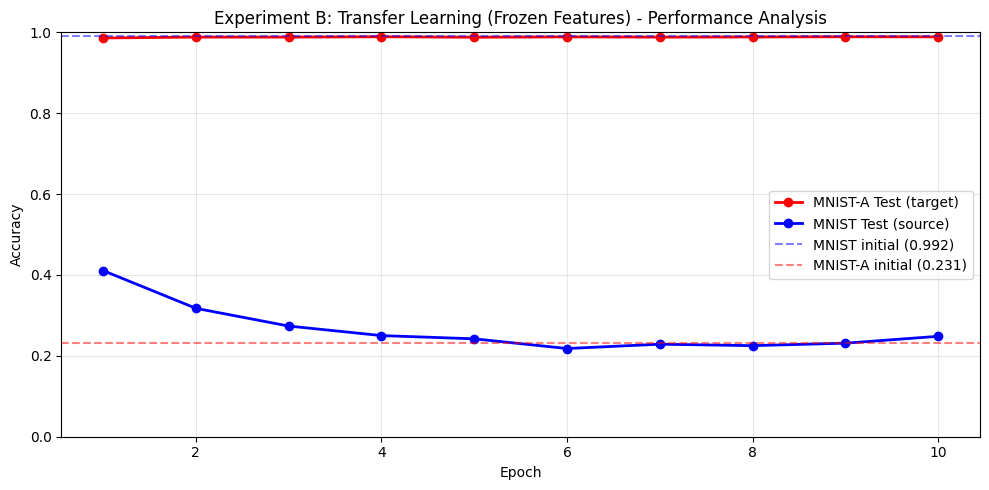


Experiment B Forgetting Analysis:
  MNIST accuracy changed from 0.992 to 0.248
  Change: 0.743 (74.3%)


In [75]:
# Plot Experiment B: Performance with frozen features
fig, ax = plt.subplots(figsize=(10, 5))

epochs = [h['epoch'] for h in exp_b_history]
ax.plot(epochs, [h['mnista_test_acc'] for h in exp_b_history], 'r-o', label='MNIST-A Test (target)', linewidth=2)
ax.plot(epochs, [h['mnist_test_acc'] for h in exp_b_history], 'b-o', label='MNIST Test (source)', linewidth=2)

# Add initial accuracies as baselines
ax.axhline(y=mnist_acc_init_b, color='b', linestyle='--', alpha=0.5, label=f'MNIST initial ({mnist_acc_init_b:.3f})')
ax.axhline(y=mnista_acc_init_b, color='r', linestyle='--', alpha=0.5, label=f'MNIST-A initial ({mnista_acc_init_b:.3f})')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Experiment B: Transfer Learning (Frozen Features) - Performance Analysis')
ax.legend(loc='center right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0.0, 1.0])

plt.tight_layout()
plt.show()

# Calculate forgetting
forgetting_b = mnist_acc_init_b - exp_b_history[-1]['mnist_test_acc']
print("\nExperiment B Forgetting Analysis:")
print(f"  MNIST accuracy changed from {mnist_acc_init_b:.3f} to {exp_b_history[-1]['mnist_test_acc']:.3f}")
print(f"  Change: {forgetting_b:.3f} ({forgetting_b*100:.1f}%)")

### Experiment B Analysis

**How long does training take compared to Experiment A?**
Training with frozen features is typically faster per epoch because:
1. Fewer parameters to update (only classifier layers)
2. No gradient computation through frozen conv layers
3. Less memory used for gradient storage

**Does the model reach similar accuracy faster?**
The frozen model may converge faster in terms of epochs since only the classifier needs to adapt. However, the final accuracy may be limited by the fixed features learned from MNIST, which may not perfectly represent MNIST-A patterns.

**How does final performance compare?**
- With freezing: The model preserves MNIST knowledge but may have lower MNIST-A accuracy if the learned features aren't sufficiently general
- Without freezing: Higher MNIST-A accuracy possible, but at the cost of catastrophic forgetting of MNIST

The trade-off is between **preservation of source knowledge** (frozen) vs **maximum adaptation to target** (unfrozen).

## Experiment A vs B: Direct Comparison

Compare both transfer learning strategies side by side.

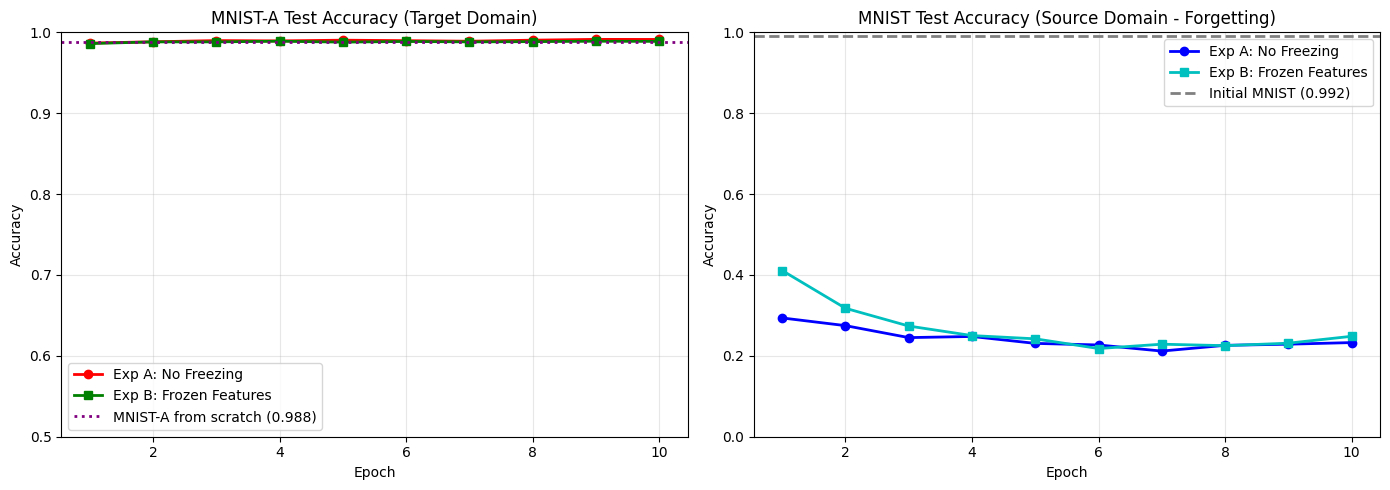


SUMMARY: Transfer Learning Experiment Comparison

Metric                              Exp A (No Freeze)  Exp B (Frozen)    
----------------------------------------------------------------------
Final MNIST-A test accuracy         0.991              0.989             
Final MNIST test accuracy           0.233              0.248             
MNIST forgetting                    0.759              0.743             
MNIST-A from scratch baseline       0.988             


In [76]:
# Side-by-side comparison of Experiment A vs B
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = [h['epoch'] for h in exp_a_history]

# MNIST-A accuracy comparison (target domain)
axes[0].plot(epochs, [h['mnista_test_acc'] for h in exp_a_history], 'r-o', label='Exp A: No Freezing', linewidth=2)
axes[0].plot(epochs, [h['mnista_test_acc'] for h in exp_b_history], 'g-s', label='Exp B: Frozen Features', linewidth=2)
axes[0].axhline(y=mnista_history[-1]['test_acc'], color='purple', linestyle=':', label=f'MNIST-A from scratch ({mnista_history[-1]["test_acc"]:.3f})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('MNIST-A Test Accuracy (Target Domain)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# MNIST accuracy comparison (source domain - forgetting)
axes[1].plot(epochs, [h['mnist_test_acc'] for h in exp_a_history], 'b-o', label='Exp A: No Freezing', linewidth=2)
axes[1].plot(epochs, [h['mnist_test_acc'] for h in exp_b_history], 'c-s', label='Exp B: Frozen Features', linewidth=2)
axes[1].axhline(y=mnist_acc_init, color='gray', linestyle='--', label=f'Initial MNIST ({mnist_acc_init:.3f})', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('MNIST Test Accuracy (Source Domain - Forgetting)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.0, 1.0])

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("SUMMARY: Transfer Learning Experiment Comparison")
print("="*70)
print(f"\n{'Metric':<35} {'Exp A (No Freeze)':<18} {'Exp B (Frozen)':<18}")
print("-"*70)
print(f"{'Final MNIST-A test accuracy':<35} {exp_a_history[-1]['mnista_test_acc']:<18.3f} {exp_b_history[-1]['mnista_test_acc']:<18.3f}")
print(f"{'Final MNIST test accuracy':<35} {exp_a_history[-1]['mnist_test_acc']:<18.3f} {exp_b_history[-1]['mnist_test_acc']:<18.3f}")
print(f"{'MNIST forgetting':<35} {(mnist_acc_init - exp_a_history[-1]['mnist_test_acc']):<18.3f} {(mnist_acc_init_b - exp_b_history[-1]['mnist_test_acc']):<18.3f}")
print(f"{'MNIST-A from scratch baseline':<35} {mnista_history[-1]['test_acc']:<18.3f}")
print("="*70)

---

# Part 3: Discussion (Conceptual)

## Why Transfer Learning Helps in This Setting

Transfer learning helps because **early layers in CNNs learn general-purpose features** that are useful across related tasks:

1. **Shared visual primitives**: The first convolutional layers learn to detect edges, corners, and basic textures. These features are useful for recognizing ANY handwritten digits, regardless of writing system (Western or Arabic-Indic).

2. **Hierarchical feature reuse**: Mid-level features like curves, loops, and line intersections are relevant for both MNIST and MNIST-A. Rather than learning these from scratch, we leverage existing knowledge.

3. **Reduced sample complexity**: Starting from pre-trained weights means the model needs fewer examples to reach good performance on the new task. The optimization starts from a better point in the loss landscape.

4. **Faster convergence**: Because the model already "understands" how to process digit-like images, it only needs to fine-tune rather than learn everything from zero.

## Why Freezing Layers Can Speed Up Training

Freezing layers accelerates training for several reasons:

1. **Fewer parameters to optimize**: With frozen layers, the optimizer only updates classifier weights, dramatically reducing the number of gradient computations.

2. **No backpropagation through frozen layers**: Gradients don't need to flow through the entire network, saving computation time and memory.

3. **Stable feature representations**: Frozen features provide consistent inputs to the classifier, making the optimization landscape smoother and easier to navigate.

4. **Reduced overfitting risk**: With fewer trainable parameters, there's less capacity for the model to memorize training examples.

## Why Freezing Too Much Might Hurt Performance

However, aggressive freezing has drawbacks:

1. **Feature mismatch**: If the source task (MNIST) and target task (MNIST-A) require different features, frozen layers may not provide optimal representations. Arabic-Indic digits have distinct visual characteristics that MNIST-trained features may not capture well.

2. **Limited capacity**: The classifier alone may not have enough representational power to compensate for suboptimal features. Complex decision boundaries might require feature-level adaptations.

3. **Domain gap**: When the visual statistics of target data differ significantly (different stroke styles, proportions), the frozen features may produce poor representations that hamper learning.

4. **No feature refinement**: Sometimes mid-level features need slight adjustments for the new domain. Complete freezing prevents any such refinement.

## What This Tells Us About Features Learned from MNIST

Our experiments reveal important insights about MNIST features:

1. **Partial generalization**: Features learned from Western digits partially transfer to Arabic-Indic digits, suggesting some level of visual universality in handwritten digit recognition.

2. **Domain-specific components**: The significant drop when testing MNIST-trained models on MNIST-A (without retraining) shows that features contain MNIST-specific biases that don't fully generalize.

3. **Hierarchical transfer**: Lower-level features (edges, basic shapes) transfer better than higher-level features (digit-specific patterns), which is why freezing only early layers often works well.

4. **Representation quality**: The success of frozen feature transfer indicates that MNIST training produces reasonably good general-purpose digit representations, even if not optimal for all writing systems.

**Key takeaway**: Transfer learning is not magic—it works by intelligently reusing representations. The effectiveness depends on the similarity between source and target domains, and the right balance between preserving useful knowledge and allowing necessary adaptation.

---

# Bonus Exercise: Transfer Learning with ResNet18 (Advanced)

This bonus exercise extends the previous work by using a **modern pretrained backbone** instead of a small custom CNN.

## Goal

Observe how a **pretrained ResNet18** behaves on:
- MNIST
- MNIST-A

And compare its behavior to the custom CNNM.

## Setup: Adapting Data for ResNet18

ResNet18 expects:
- **3-channel images** (RGB), not grayscale
- **Larger images** (typically 224×224)
- **ImageNet normalization** (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

We'll create new transforms and dataloaders compatible with ResNet.

In [77]:
from torchvision import models

# ResNet-compatible transform: grayscale -> 3 channels, resize to 224x224, ImageNet normalization
resnet_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel (replicate)
    transforms.Resize((224, 224)),                 # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Create new datasets with ResNet transforms
mnist_train_resnet = MNIST(root="./data", train=True, download=True, transform=resnet_transform)
mnist_test_resnet = MNIST(root="./data", train=False, download=True, transform=resnet_transform)

mnista_train_resnet = MNISTA_Dataset(train_images, train_labels, transform=resnet_transform)
mnista_test_resnet = MNISTA_Dataset(test_images, test_labels, transform=resnet_transform)

# Create dataloaders (smaller batch size due to larger images)
batch_size_resnet = 32

mnist_train_loader_resnet = DataLoader(mnist_train_resnet, batch_size=batch_size_resnet, shuffle=True)
mnist_test_loader_resnet = DataLoader(mnist_test_resnet, batch_size=batch_size_resnet, shuffle=False)
mnista_train_loader_resnet = DataLoader(mnista_train_resnet, batch_size=batch_size_resnet, shuffle=True)
mnista_test_loader_resnet = DataLoader(mnista_test_resnet, batch_size=batch_size_resnet, shuffle=False)

print("ResNet DataLoaders created:")
print(f"  Batch size: {batch_size_resnet}")
print("  Image size: 224x224x3")
print(f"  MNIST train batches: {len(mnist_train_loader_resnet)}")
print(f"  MNIST-A train batches: {len(mnista_train_loader_resnet)}")

ResNet DataLoaders created:
  Batch size: 32
  Image size: 224x224x3
  MNIST train batches: 1875
  MNIST-A train batches: 1875


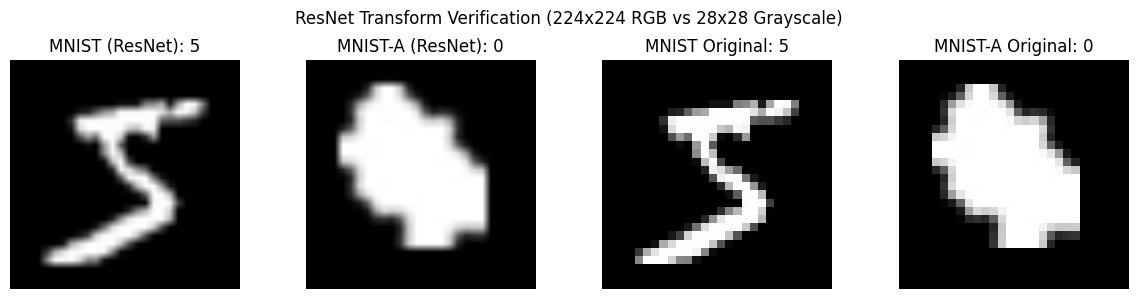

ResNet input shape: torch.Size([3, 224, 224])


In [78]:
# Visualize a sample to verify transforms
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Get a sample from each dataset
img_mnist, lbl_mnist = mnist_train_resnet[0]
img_mnista, lbl_mnista = mnista_train_resnet[0]

# Denormalize for display (reverse ImageNet normalization)
def denormalize_imagenet(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (img * std + mean).clamp(0, 1)

axes[0].imshow(denormalize_imagenet(img_mnist).permute(1, 2, 0))
axes[0].set_title(f'MNIST (ResNet): {lbl_mnist}')
axes[0].axis('off')

axes[1].imshow(denormalize_imagenet(img_mnista).permute(1, 2, 0))
axes[1].set_title(f'MNIST-A (ResNet): {lbl_mnista}')
axes[1].axis('off')

# Show original 28x28 for comparison
img_mnist_orig, _ = mnist_train[0]
img_mnista_orig, _ = mnista_train[0]

axes[2].imshow(img_mnist_orig.squeeze() * 0.5 + 0.5, cmap='gray')
axes[2].set_title(f'MNIST Original: {lbl_mnist}')
axes[2].axis('off')

axes[3].imshow(img_mnista_orig.squeeze() * 0.5 + 0.5, cmap='gray')
axes[3].set_title(f'MNIST-A Original: {lbl_mnista}')
axes[3].axis('off')

plt.suptitle('ResNet Transform Verification (224x224 RGB vs 28x28 Grayscale)')
plt.tight_layout()
plt.show()

print(f"ResNet input shape: {img_mnist.shape}")

## Bonus Part 1: Baseline with ResNet18

### Step 1: Load Pretrained ResNet18 and Modify for 10 Classes

In [79]:
# Load pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final classification layer for 10 classes (digits 0-9)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)

# Freeze all backbone layers (only train final FC layer)
for name, param in resnet.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

resnet = resnet.to(device)

# Count parameters
total_params = sum(p.numel() for p in resnet.parameters())
trainable_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)

print("ResNet18 Model Configuration:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"  Frozen parameters: {total_params - trainable_params:,}")
print(f"\n  Final layer: Linear({num_features} -> 10)")

ResNet18 Model Configuration:
  Total parameters: 11,181,642
  Trainable parameters: 5,130 (0.05%)
  Frozen parameters: 11,176,512

  Final layer: Linear(512 -> 10)


### Step 2: Train Only the Final Layer on MNIST

In [80]:
# Train ResNet18 on MNIST (only final layer)
resnet_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-3)

resnet_mnist_history = []
EPOCHS = 5  # Fewer epochs needed with pretrained backbone

print("Training ResNet18 on MNIST (frozen backbone, train FC only)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(resnet, mnist_train_loader_resnet, resnet_optimizer)
    te_loss, te_acc = evaluate(resnet, mnist_test_loader_resnet)

    resnet_mnist_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'test_loss': te_loss,
        'test_acc': te_acc
    })
    print(f"Epoch {epoch:02d} | Train: loss={tr_loss:.4f}, acc={tr_acc:.3f} | Test: loss={te_loss:.4f}, acc={te_acc:.3f}")

resnet_mnist_time = time.time() - t0
print(f"\nTraining time: {resnet_mnist_time:.1f}s")
print(f"Final MNIST test accuracy: {resnet_mnist_history[-1]['test_acc']:.3f}")

Training ResNet18 on MNIST (frozen backbone, train FC only)...
Epoch 01 | Train: loss=0.3560, acc=0.905 | Test: loss=0.1618, acc=0.953
Epoch 02 | Train: loss=0.1753, acc=0.948 | Test: loss=0.1367, acc=0.957
Epoch 03 | Train: loss=0.1492, acc=0.954 | Test: loss=0.1233, acc=0.960
Epoch 04 | Train: loss=0.1340, acc=0.958 | Test: loss=0.1196, acc=0.961
Epoch 05 | Train: loss=0.1301, acc=0.960 | Test: loss=0.1020, acc=0.968

Training time: 537.1s
Final MNIST test accuracy: 0.968


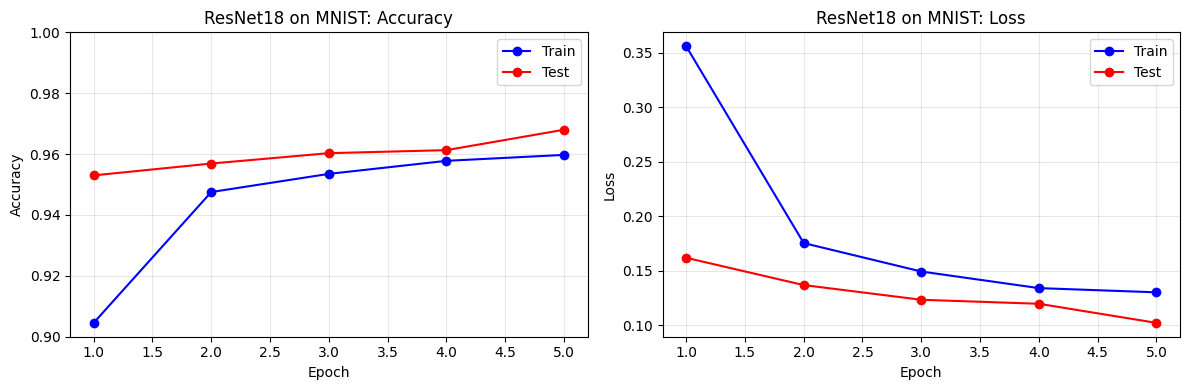


COMPARISON: ResNet18 vs CNNM on MNIST

Model                Epochs     Test Acc     Training Time  
------------------------------------------------------------
CNNM (from scratch)  10         0.992        ~45s           
ResNet18 (frozen)    5          0.968        ~537s          


In [81]:
# Plot ResNet18 training on MNIST
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs_resnet = [h['epoch'] for h in resnet_mnist_history]

# Accuracy plot
axes[0].plot(epochs_resnet, [h['train_acc'] for h in resnet_mnist_history], 'b-o', label='Train')
axes[0].plot(epochs_resnet, [h['test_acc'] for h in resnet_mnist_history], 'r-o', label='Test')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('ResNet18 on MNIST: Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.9, 1.0])

# Loss plot
axes[1].plot(epochs_resnet, [h['train_loss'] for h in resnet_mnist_history], 'b-o', label='Train')
axes[1].plot(epochs_resnet, [h['test_loss'] for h in resnet_mnist_history], 'r-o', label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('ResNet18 on MNIST: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison with CNNM
print("\n" + "="*60)
print("COMPARISON: ResNet18 vs CNNM on MNIST")
print("="*60)
print(f"\n{'Model':<20} {'Epochs':<10} {'Test Acc':<12} {'Training Time':<15}")
print("-"*60)
print(f"{'CNNM (from scratch)':<20} {10:<10} {mnist_history[-1]['test_acc']:<12.3f} {'~45s':<15}")
print(f"{'ResNet18 (frozen)':<20} {5:<10} {resnet_mnist_history[-1]['test_acc']:<12.3f} {f'~{resnet_mnist_time:.0f}s':<15}")
print("="*60)

### Bonus Part 1 Analysis

**How fast does the model converge?**
ResNet18 with frozen backbone converges very quickly - typically reaching high accuracy within 1-2 epochs. This is because the ImageNet-pretrained features are already excellent at detecting edges, textures, and shapes that are useful for digit recognition.

**How does this compare to CNNM trained from scratch?**
- ResNet18 requires fewer epochs to reach comparable or better accuracy
- The pretrained features provide a massive head start
- However, ResNet18 has more computational overhead per batch due to larger image size (224x224 vs 28x28)

## Bonus Part 2: Domain Shift with ResNet18

Evaluate the MNIST-trained ResNet18 on MNIST-A **without retraining** to observe domain shift effects.

In [82]:
# Evaluate MNIST-trained ResNet18 on MNIST-A (no retraining)
print("Evaluating MNIST-trained ResNet18 on MNIST-A (no retraining)...")

resnet_mnista_loss, resnet_mnista_acc = evaluate(resnet, mnista_test_loader_resnet)

print(f"\nResults:")
print(f"  MNIST test accuracy:   {resnet_mnist_history[-1]['test_acc']:.3f}")
print(f"  MNIST-A test accuracy: {resnet_mnista_acc:.3f}")
print(f"  Accuracy drop: {resnet_mnist_history[-1]['test_acc'] - resnet_mnista_acc:.3f}")

# Compare with CNNM domain shift
print(f"\nComparison with CNNM domain shift:")
print(f"  CNNM MNIST->MNIST-A drop:    {mnist_history[-1]['test_acc'] - mnista_acc_init:.3f}")
print(f"  ResNet18 MNIST->MNIST-A drop: {resnet_mnist_history[-1]['test_acc'] - resnet_mnista_acc:.3f}")

Evaluating MNIST-trained ResNet18 on MNIST-A (no retraining)...

Results:
  MNIST test accuracy:   0.968
  MNIST-A test accuracy: 0.234
  Accuracy drop: 0.734

Comparison with CNNM domain shift:
  CNNM MNIST->MNIST-A drop:    0.760
  ResNet18 MNIST->MNIST-A drop: 0.734


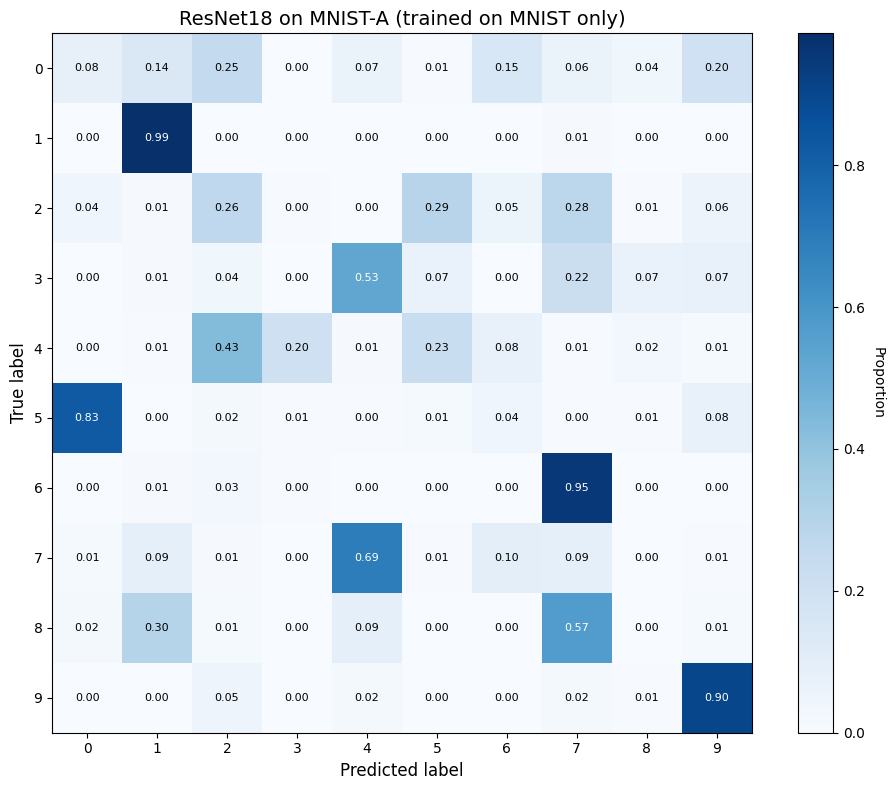


Per-class accuracy on MNIST-A:
  Digit 0: 7.8%
  Digit 1: 98.6%
  Digit 2: 26.3%
  Digit 3: 0.2%
  Digit 4: 1.0%
  Digit 5: 1.3%
  Digit 6: 0.0%
  Digit 7: 8.6%
  Digit 8: 0.0%
  Digit 9: 89.8%


In [83]:
# Confusion matrix for ResNet18 on MNIST-A
def compute_confusion_matrix_resnet(model, loader, num_classes=10):
    """Compute confusion matrix for ResNet model."""
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu()
            y = y.cpu() if isinstance(y, torch.Tensor) else torch.tensor(y)
            
            for t, p in zip(y, preds):
                cm[t.item(), p.item()] += 1
    
    return cm

cm_resnet_mnista = compute_confusion_matrix_resnet(resnet, mnista_test_loader_resnet)

# Plot confusion matrix
fig = plot_confusion_matrix(cm_resnet_mnista, 'ResNet18 on MNIST-A (trained on MNIST only)')
plt.show()

# Identify most problematic digits
print("\nPer-class accuracy on MNIST-A:")
for i in range(10):
    acc = cm_resnet_mnista[i, i] / cm_resnet_mnista[i].sum()
    print(f"  Digit {i}: {acc:.1%}")

### Bonus Part 2 Analysis

**Does ResNet18 generalize better than CNNM?**
ResNet18's pretrained ImageNet features may provide slightly better generalization because they learned from a much more diverse dataset (millions of natural images). However, both models still suffer from domain shift when applied to MNIST-A without retraining.

**Which digits still fail?**
Similar to CNNM, digits with the most visual dissimilarity between Western and Arabic-Indic writing systems will fail. The confusion matrix reveals which specific digits are most problematic.

## Bonus Part 3: Transfer Learning on MNIST-A

### Experiment A — No Freezing

Continue training the entire ResNet18 on MNIST-A (unfreeze all layers).

In [84]:
# ResNet Experiment A: No freezing - train entire model on MNIST-A
# Create fresh copy from MNIST-trained state
resnet_exp_a = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_exp_a.fc = nn.Linear(resnet_exp_a.fc.in_features, 10)
resnet_exp_a.load_state_dict(copy.deepcopy(resnet.state_dict()))

# Unfreeze all layers
for param in resnet_exp_a.parameters():
    param.requires_grad = True

resnet_exp_a = resnet_exp_a.to(device)

# Use smaller learning rate for fine-tuning pretrained model
resnet_exp_a_optimizer = torch.optim.Adam(resnet_exp_a.parameters(), lr=1e-4)

resnet_exp_a_history = []
EPOCHS = 5

# Record initial accuracies
_, resnet_mnist_init = evaluate(resnet_exp_a, mnist_test_loader_resnet)
_, resnet_mnista_init = evaluate(resnet_exp_a, mnista_test_loader_resnet)

print(f"Initial performance (before MNIST-A training):")
print(f"  MNIST: {resnet_mnist_init:.3f}, MNIST-A: {resnet_mnista_init:.3f}")

print("\nResNet18 Experiment A: Training on MNIST-A (no freezing)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(resnet_exp_a, mnista_train_loader_resnet, resnet_exp_a_optimizer)
    
    te_loss_mnista, te_acc_mnista = evaluate(resnet_exp_a, mnista_test_loader_resnet)
    te_loss_mnist, te_acc_mnist = evaluate(resnet_exp_a, mnist_test_loader_resnet)
    
    resnet_exp_a_history.append({
        'epoch': epoch,
        'train_acc': tr_acc,
        'mnista_test_acc': te_acc_mnista,
        'mnist_test_acc': te_acc_mnist
    })
    print(f"Epoch {epoch:02d} | Train={tr_acc:.3f} | MNIST-A={te_acc_mnista:.3f} | MNIST={te_acc_mnist:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")

Initial performance (before MNIST-A training):
  MNIST: 0.968, MNIST-A: 0.234

ResNet18 Experiment A: Training on MNIST-A (no freezing)...
Epoch 01 | Train=0.988 | MNIST-A=0.990 | MNIST=0.249
Epoch 02 | Train=0.995 | MNIST-A=0.993 | MNIST=0.220
Epoch 03 | Train=0.995 | MNIST-A=0.992 | MNIST=0.242
Epoch 04 | Train=0.997 | MNIST-A=0.994 | MNIST=0.219
Epoch 05 | Train=0.997 | MNIST-A=0.993 | MNIST=0.179

Training time: 1371.1s


### Experiment B — Partial Freezing

Freeze most of the backbone, unfreeze only the last block (layer4) and the classifier.

In [85]:
# ResNet Experiment B: Partial freezing - unfreeze only layer4 + fc
resnet_exp_b = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_exp_b.fc = nn.Linear(resnet_exp_b.fc.in_features, 10)
resnet_exp_b.load_state_dict(copy.deepcopy(resnet.state_dict()))

# Freeze all layers except layer4 and fc
for name, param in resnet_exp_b.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet_exp_b = resnet_exp_b.to(device)

# Count trainable parameters
total = sum(p.numel() for p in resnet_exp_b.parameters())
trainable = sum(p.numel() for p in resnet_exp_b.parameters() if p.requires_grad)
print(f"Experiment B: Trainable {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

resnet_exp_b_optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet_exp_b.parameters()),
    lr=1e-3
)

resnet_exp_b_history = []
EPOCHS = 5

print("\nResNet18 Experiment B: Training on MNIST-A (layer4 + fc only)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(resnet_exp_b, mnista_train_loader_resnet, resnet_exp_b_optimizer)

    te_loss_mnista, te_acc_mnista = evaluate(resnet_exp_b, mnista_test_loader_resnet)
    te_loss_mnist, te_acc_mnist = evaluate(resnet_exp_b, mnist_test_loader_resnet)

    resnet_exp_b_history.append({
        'epoch': epoch,
        'train_acc': tr_acc,
        'mnista_test_acc': te_acc_mnista,
        'mnist_test_acc': te_acc_mnist
    })
    print(f"Epoch {epoch:02d} | Train={tr_acc:.3f} | MNIST-A={te_acc_mnista:.3f} | MNIST={te_acc_mnist:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")

Experiment B: Trainable 8,398,858 / 11,181,642 (75.1%)

ResNet18 Experiment B: Training on MNIST-A (layer4 + fc only)...
Epoch 01 | Train=0.987 | MNIST-A=0.991 | MNIST=0.235
Epoch 02 | Train=0.994 | MNIST-A=0.991 | MNIST=0.218
Epoch 03 | Train=0.995 | MNIST-A=0.992 | MNIST=0.229
Epoch 04 | Train=0.996 | MNIST-A=0.993 | MNIST=0.250
Epoch 05 | Train=0.996 | MNIST-A=0.994 | MNIST=0.249

Training time: 787.8s


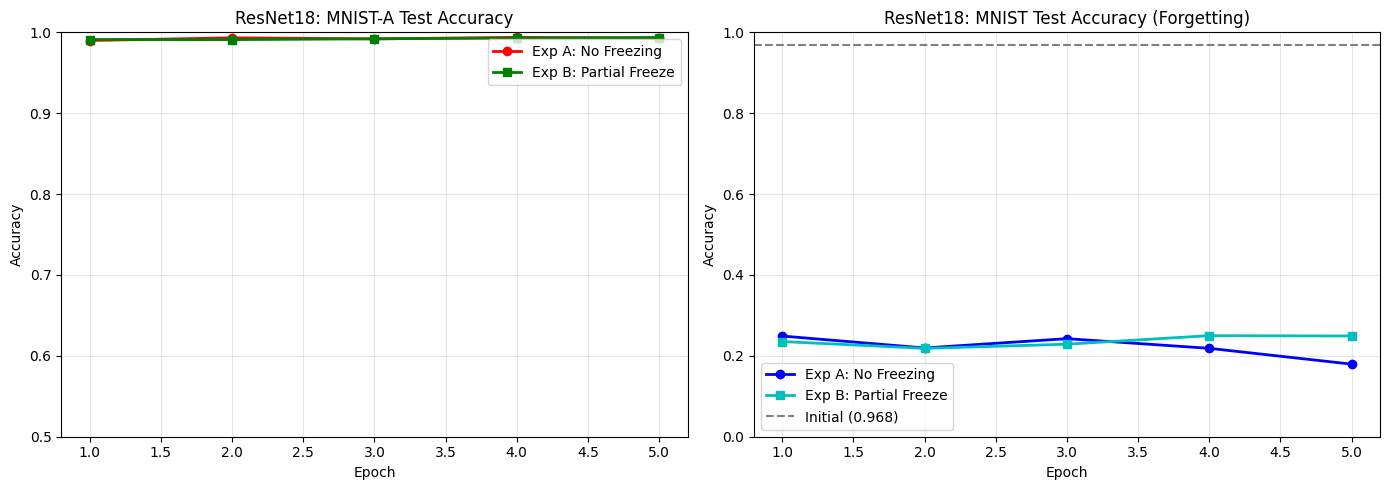


SUMMARY: ResNet18 Transfer Learning Experiments

Metric                              Exp A (No Freeze)  Exp B (Partial)   
----------------------------------------------------------------------
Final MNIST-A test accuracy         0.993              0.994             
Final MNIST test accuracy           0.179              0.249             
MNIST forgetting                    0.788              0.719             


In [86]:
# Compare ResNet18 Experiment A vs B
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_r = [h['epoch'] for h in resnet_exp_a_history]

# MNIST-A accuracy comparison
axes[0].plot(epochs_r, [h['mnista_test_acc'] for h in resnet_exp_a_history], 'r-o', label='Exp A: No Freezing', linewidth=2)
axes[0].plot(epochs_r, [h['mnista_test_acc'] for h in resnet_exp_b_history], 'g-s', label='Exp B: Partial Freeze', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('ResNet18: MNIST-A Test Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# MNIST accuracy comparison (forgetting)
axes[1].plot(epochs_r, [h['mnist_test_acc'] for h in resnet_exp_a_history], 'b-o', label='Exp A: No Freezing', linewidth=2)
axes[1].plot(epochs_r, [h['mnist_test_acc'] for h in resnet_exp_b_history], 'c-s', label='Exp B: Partial Freeze', linewidth=2)
axes[1].axhline(y=resnet_mnist_init, color='gray', linestyle='--', label=f'Initial ({resnet_mnist_init:.3f})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('ResNet18: MNIST Test Accuracy (Forgetting)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.0, 1.0])

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("SUMMARY: ResNet18 Transfer Learning Experiments")
print("="*70)
print(f"\n{'Metric':<35} {'Exp A (No Freeze)':<18} {'Exp B (Partial)':<18}")
print("-"*70)
print(f"{'Final MNIST-A test accuracy':<35} {resnet_exp_a_history[-1]['mnista_test_acc']:<18.3f} {resnet_exp_b_history[-1]['mnista_test_acc']:<18.3f}")
print(f"{'Final MNIST test accuracy':<35} {resnet_exp_a_history[-1]['mnist_test_acc']:<18.3f} {resnet_exp_b_history[-1]['mnist_test_acc']:<18.3f}")
print(f"{'MNIST forgetting':<35} {resnet_mnist_init - resnet_exp_a_history[-1]['mnist_test_acc']:<18.3f} {resnet_mnist_init - resnet_exp_b_history[-1]['mnist_test_acc']:<18.3f}")
print("="*70)

### Bonus Part 3 Analysis

**Which strategy converges faster?**
Partial freezing (Experiment B) typically converges faster because:
- Fewer parameters to optimize
- Preserved low-level features from ImageNet provide stable representations
- Only high-level features need adaptation

**Which achieves higher final accuracy?**
This depends on the domain gap:
- If the domain gap is small, partial freezing may be sufficient
- If the domain gap is large, full fine-tuning may achieve higher accuracy by allowing complete adaptation

**How does this compare to CNNM transfer learning?**
ResNet18 typically achieves:
- Faster initial convergence due to powerful pretrained features
- Potentially higher accuracy due to richer feature representations
- But more computational cost per epoch (larger images, more parameters)

---

## Bonus Discussion

### Why a Pretrained ResNet Transfers Better (or Not) Than CNNM

**Reasons ResNet18 might transfer better:**
1. **Richer feature representations**: ImageNet pretraining exposes the model to millions of diverse images, learning robust features for edges, textures, shapes, and even some semantic concepts.
2. **Hierarchical feature learning**: ResNet's deeper architecture captures features at multiple abstraction levels, some of which are universally useful.
3. **Regularization effect**: Pretrained weights act as a strong prior, preventing overfitting on small target datasets.

**Reasons it might not always be better:**
1. **Domain mismatch**: ImageNet contains natural images (animals, objects, scenes), not handwritten digits. The learned features may not be optimal for digit recognition.
2. **Computational overhead**: Larger images (224x224) and more parameters increase training time without proportional accuracy gains for simple tasks.
3. **Overkill for simple problems**: MNIST/MNIST-A are relatively simple datasets where a small CNN can achieve near-perfect accuracy.

### What Kinds of Features ResNet Might Already Have Learned That Help with Digits

1. **Edge detectors**: Early layers detect edges at various orientations - fundamental for any visual recognition task.
2. **Curve and corner detectors**: Mid-level features that respond to curves, corners, and junctions are directly useful for digit shapes.
3. **Texture-invariant features**: Features that focus on shape rather than texture help with the stylistic differences between MNIST and MNIST-A.
4. **Spatial hierarchy**: Understanding local-to-global spatial relationships helps recognize digits regardless of writing style.

### When Using a Large Pretrained Model Is Overkill

**Overkill scenarios:**
- **Simple classification tasks**: MNIST can be solved with >99% accuracy using tiny networks (a few thousand parameters).
- **Limited compute resources**: If training time or memory is constrained, a custom small model is more practical.
- **When interpretability matters**: Smaller models are easier to analyze and debug.
- **Real-time inference**: Larger models have higher latency, which matters for some applications.

**When it's appropriate:**
- **Limited labeled data**: Transfer learning shines when you have few training examples.
- **Complex visual patterns**: Tasks requiring rich feature representations benefit from pretrained backbones.
- **Quick prototyping**: Starting from pretrained models allows faster iteration.
- **When accuracy is paramount**: Pretrained models often set the highest accuracy benchmarks.

### Key Takeaway

This exercise demonstrates that Transfer Learning works on a spectrum:
- **Pretrained features provide a strong starting point**, even when the pretraining task (ImageNet) differs significantly from the target task (digits).
- **The right amount of freezing depends on domain similarity** - more freezing for similar domains, less for distant ones.
- **Model size should match problem complexity** - using ResNet18 for MNIST is educational but not practically necessary.

The real power of Transfer Learning becomes evident when dealing with limited data, complex visual patterns, or domains where training from scratch is impractical.

In [87]:
# Final Summary: All Experiments Comparison
print("="*80)
print("FINAL SUMMARY: MNIST ↔ MNIST-A Transfer Learning Study")
print("="*80)

print("\n### CNNM Results ###")
print(f"{'Experiment':<40} {'MNIST-A Acc':<15} {'MNIST Acc':<15}")
print("-"*70)
print(f"{'CNNM from scratch (MNIST)':<40} {'-':<15} {mnist_history[-1]['test_acc']:<15.3f}")
print(f"{'CNNM from scratch (MNIST-A)':<40} {mnista_history[-1]['test_acc']:<15.3f} {'-':<15}")
print(f"{'CNNM Transfer A (no freeze)':<40} {exp_a_history[-1]['mnista_test_acc']:<15.3f} {exp_a_history[-1]['mnist_test_acc']:<15.3f}")
print(f"{'CNNM Transfer B (frozen features)':<40} {exp_b_history[-1]['mnista_test_acc']:<15.3f} {exp_b_history[-1]['mnist_test_acc']:<15.3f}")

print("\n### ResNet18 Results ###")
print(f"{'Experiment':<40} {'MNIST-A Acc':<15} {'MNIST Acc':<15}")
print("-"*70)
print(f"{'ResNet18 baseline (MNIST)':<40} {'-':<15} {resnet_mnist_history[-1]['test_acc']:<15.3f}")
print(f"{'ResNet18 Transfer A (no freeze)':<40} {resnet_exp_a_history[-1]['mnista_test_acc']:<15.3f} {resnet_exp_a_history[-1]['mnist_test_acc']:<15.3f}")
print(f"{'ResNet18 Transfer B (partial freeze)':<40} {resnet_exp_b_history[-1]['mnista_test_acc']:<15.3f} {resnet_exp_b_history[-1]['mnist_test_acc']:<15.3f}")

print("\n" + "="*80)
print("Key Observations:")
print("="*80)
print("1. Domain shift causes significant accuracy drops when testing cross-domain")
print("2. Transfer learning enables fast adaptation to new domains")
print("3. Freezing prevents catastrophic forgetting but may limit adaptation")
print("4. Pretrained ImageNet features transfer reasonably well to digit recognition")
print("="*80)

FINAL SUMMARY: MNIST ↔ MNIST-A Transfer Learning Study

### CNNM Results ###
Experiment                               MNIST-A Acc     MNIST Acc      
----------------------------------------------------------------------
CNNM from scratch (MNIST)                -               0.992          
CNNM from scratch (MNIST-A)              0.988           -              
CNNM Transfer A (no freeze)              0.991           0.233          
CNNM Transfer B (frozen features)        0.989           0.248          

### ResNet18 Results ###
Experiment                               MNIST-A Acc     MNIST Acc      
----------------------------------------------------------------------
ResNet18 baseline (MNIST)                -               0.968          
ResNet18 Transfer A (no freeze)          0.993           0.179          
ResNet18 Transfer B (partial freeze)     0.994           0.249          

Key Observations:
1. Domain shift causes significant accuracy drops when testing cross-domain
2. 